### **Cổ phiếu**
Cổ phiếu (stock) là một trong những loại chứng khoán phổ biến nhất trên thị trường tài chính. Nó thường được phát hành bởi các công ty cổ phần để huy động vốn từ các nhà đầu tư. Khi bạn mua cổ phiếu của một công ty, bạn sẽ trở thành một trong những cổ đông của công ty đó. Cổ đông sẽ có quyền tham gia vào quản trị công ty bằng cách bỏ phiếu tại các cuộc họp cổ đông.  
Trong kinh tế, cổ phiếu đóng vai trò quan trọng trong việc huy động vốn cho công ty, giúp các công ty tăng vốn để đầu tư và phát triển hoạt động kinh doanh. Cổ phiếu cũng là một công cụ giúp các nhà đầu tư có thể đầu tư vào các công ty và được chia sẻ lợi nhuận từ hoạt động kinh doanh của công ty đó.

### **Biến động giá cổ phiếu**
Biến động giá cổ phiếu là sự thay đổi về giá của một cổ phiếu theo thời gian. Điều này có thể xảy ra khi có những thay đổi trong tình hình kinh tế, tình hình chính trị, hoạt động kinh doanh của công ty, hoặc do yếu tố tâm lý của các nhà đầu tư. Các biến động giá cổ phiếu có thể là tăng giá hoặc giảm giá, tùy thuộc vào tình hình thị trường.


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

import os
import pickle
import matplotlib.dates as mdates

import time

In [9]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
%cd "/content/drive/MyDrive/Finpros"

/content/drive/MyDrive/Finpros


In [11]:
vic_data = pd.read_csv('data/VIC.csv')
fpt_data = pd.read_csv('data/FPT.csv')
msn_data = pd.read_csv('data/MSN.csv')
pnj_data = pd.read_csv('data/PNJ.csv')
vic_data

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,VIC,10/17/2018 9:39,98.5,98.5,98.5,98.5,390,0
1,VIC,10/17/2018 9:40,98.5,98.5,98.5,98.5,760,0
2,VIC,10/17/2018 9:41,98.6,98.6,98.6,98.6,2060,0
3,VIC,10/17/2018 9:42,98.6,98.6,98.6,98.6,5540,0
4,VIC,10/17/2018 9:43,98.6,98.7,98.6,98.7,760,0
...,...,...,...,...,...,...,...,...
101261,VIC,12/22/2020 14:22,105.8,105.8,105.7,105.7,1870,0
101262,VIC,12/22/2020 14:23,105.7,105.7,105.7,105.7,2510,0
101263,VIC,12/22/2020 14:24,105.7,105.7,105.7,105.7,3620,0
101264,VIC,12/22/2020 14:25,105.7,105.7,105.7,105.7,100,0


In [12]:
print('VIC: ', vic_data.shape)
print('FPT: ', fpt_data.shape)
print('MSN: ', msn_data.shape)
print('PNJ: ', pnj_data.shape)


VIC:  (101266, 8)
FPT:  (97406, 8)
MSN:  (135354, 8)
PNJ:  (125309, 8)


In [13]:
vic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101266 entries, 0 to 101265
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         101266 non-null  object 
 1   Date/Time      101266 non-null  object 
 2   Open           101266 non-null  float64
 3   High           101266 non-null  float64
 4   Low            101266 non-null  float64
 5   Close          101266 non-null  float64
 6   Volume         101266 non-null  int64  
 7   Open Interest  101266 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 6.2+ MB


In [14]:
vic_data.describe()

,Open,High,Low,Close,Volume,Open Interest
count,101266.000000,101266.000000,101266.000000,101266.000000,1.012660e+05,101266.0
mean,105.376460,105.418519,105.334147,105.378791,3.182640e+03,0.0
std,11.543158,11.535584,11.552338,11.545054,1.469814e+04,0.0
min,68.000000,68.000000,68.000000,68.000000,1.000000e+01,0.0
25%,95.400000,95.400000,95.300000,95.400000,2.300000e+02,0.0
50%,105.300000,105.300000,105.200000,105.300000,1.020000e+03,0.0
75%,115.800000,115.900000,115.800000,115.800000,3.000000e+03,0.0
max,126.100000,126.500000,126.100000,126.500000,1.468390e+06,0.0


In [15]:
def DropUnessaryColumns(data):
    data = data.drop(['Volume','Open Interest'], axis = 1)
    return data

In [16]:
def ChangeDate(data):
    data['Date/Time'] = pd.to_datetime(data['Date/Time'])
ChangeDate(vic_data)
ChangeDate(fpt_data)
ChangeDate(msn_data)
ChangeDate(pnj_data)
vic_data

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,VIC,2018-10-17 09:39:00,98.5,98.5,98.5,98.5,390,0
1,VIC,2018-10-17 09:40:00,98.5,98.5,98.5,98.5,760,0
2,VIC,2018-10-17 09:41:00,98.6,98.6,98.6,98.6,2060,0
3,VIC,2018-10-17 09:42:00,98.6,98.6,98.6,98.6,5540,0
4,VIC,2018-10-17 09:43:00,98.6,98.7,98.6,98.7,760,0
...,...,...,...,...,...,...,...,...
101261,VIC,2020-12-22 14:22:00,105.8,105.8,105.7,105.7,1870,0
101262,VIC,2020-12-22 14:23:00,105.7,105.7,105.7,105.7,2510,0
101263,VIC,2020-12-22 14:24:00,105.7,105.7,105.7,105.7,3620,0
101264,VIC,2020-12-22 14:25:00,105.7,105.7,105.7,105.7,100,0


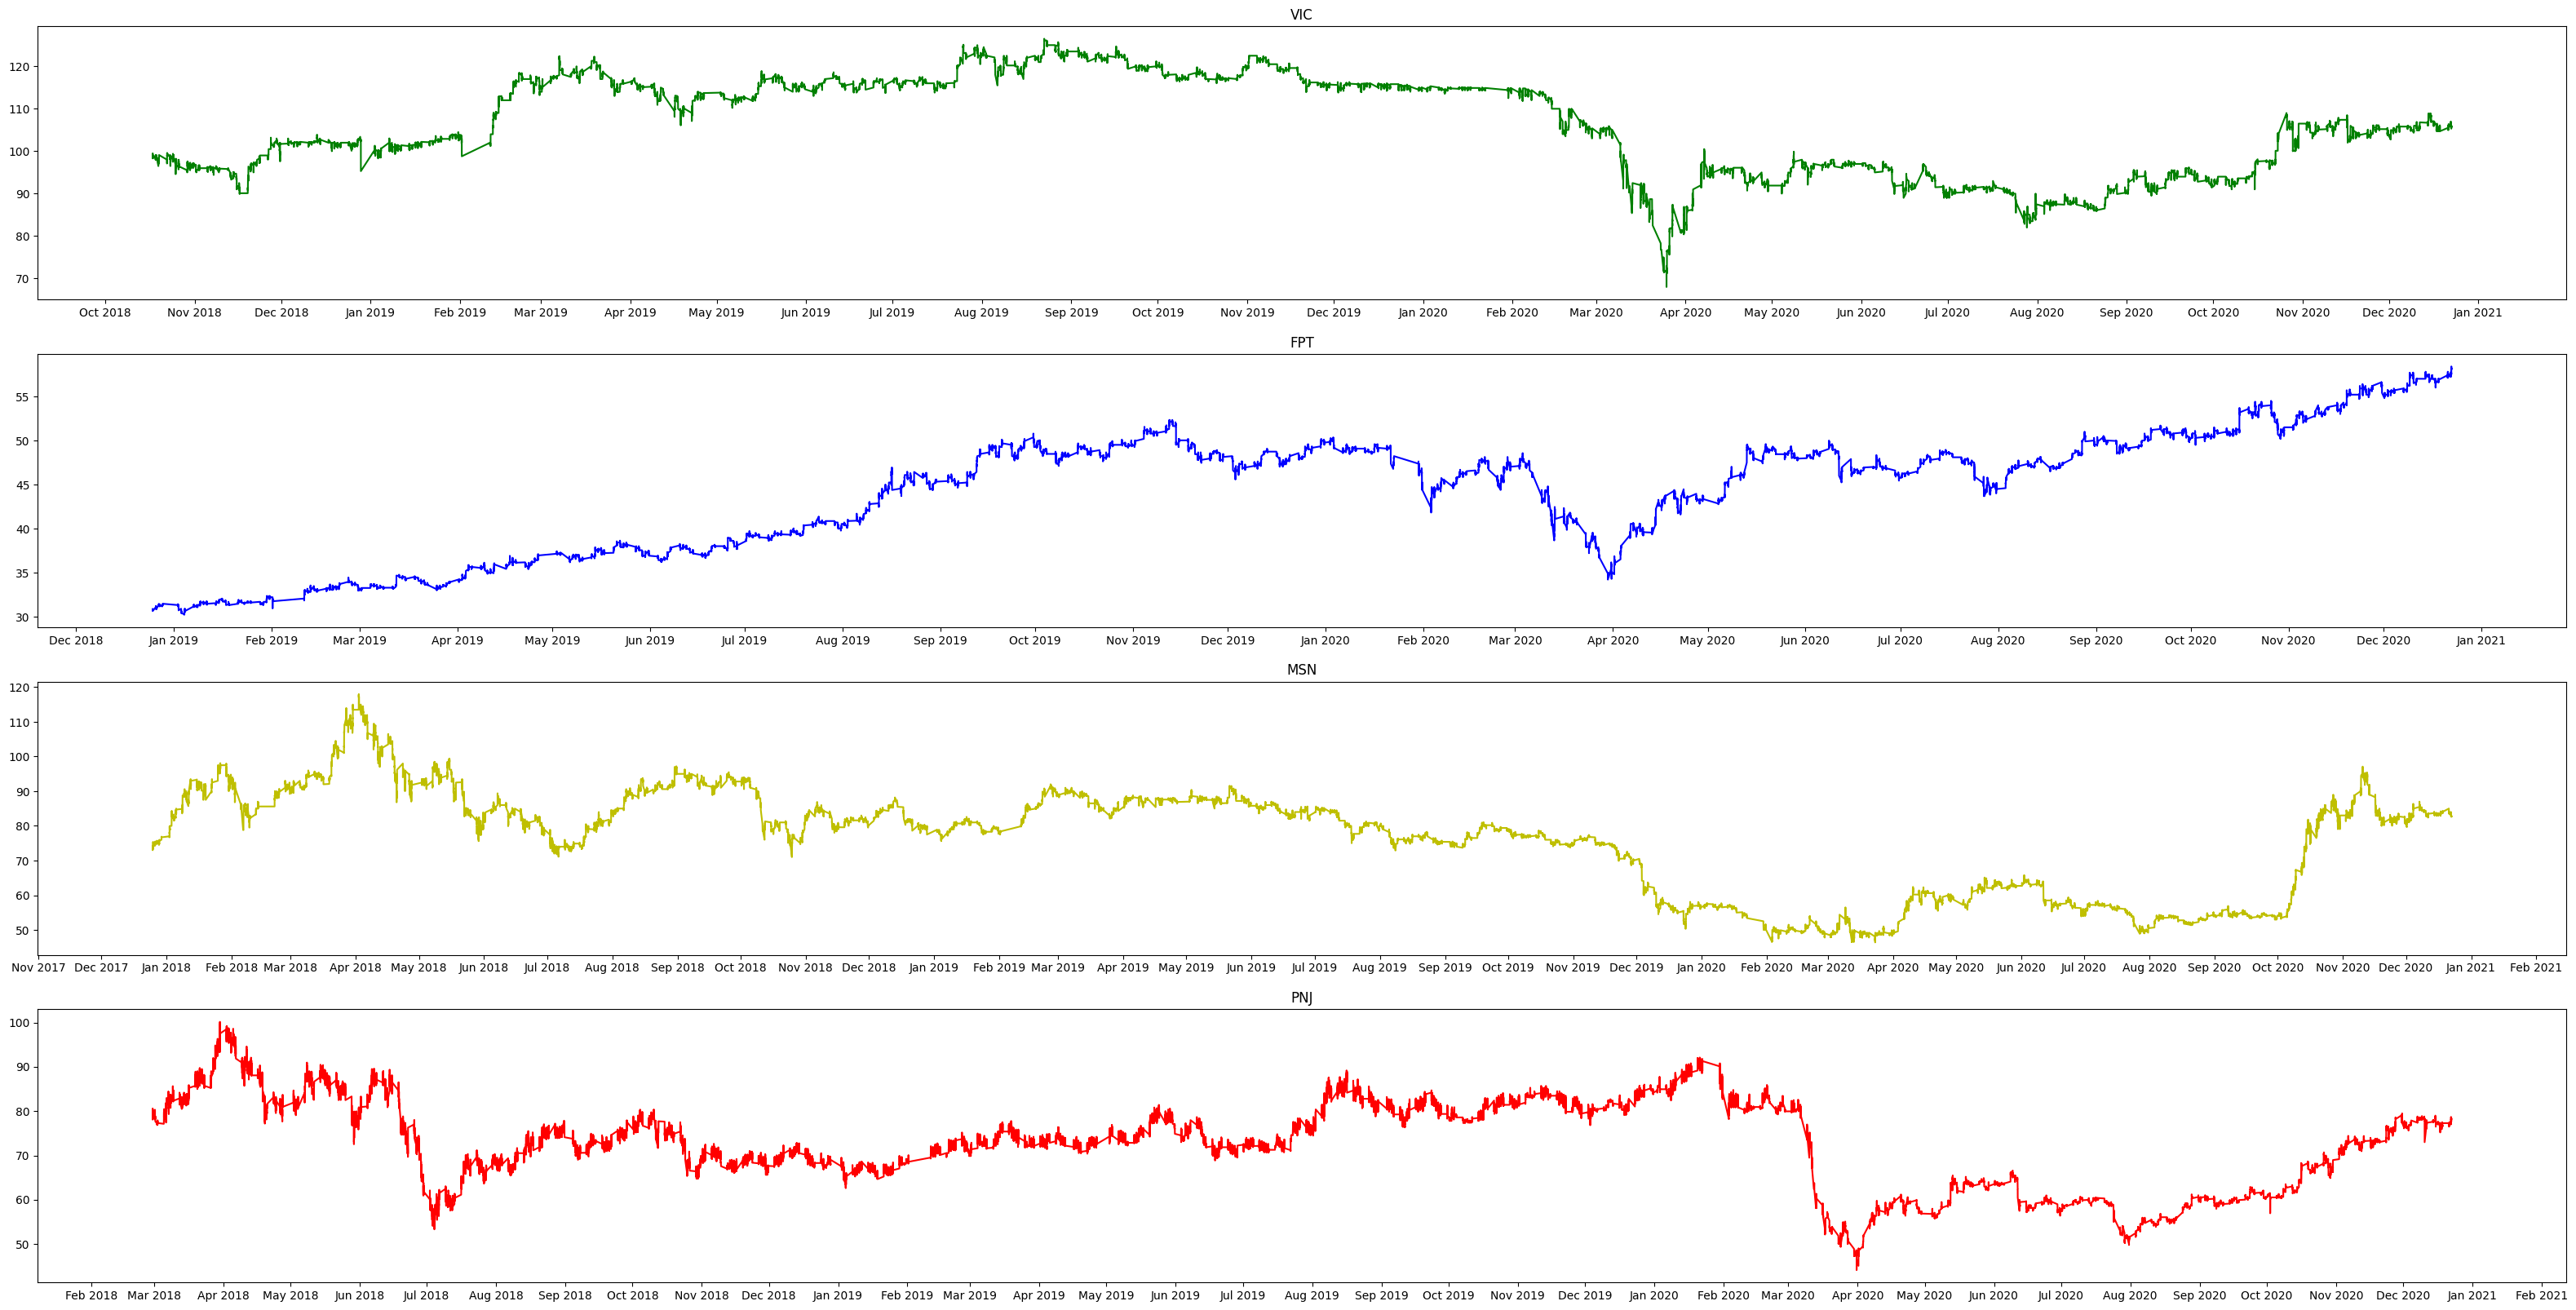

<Figure size 640x480 with 0 Axes>

In [17]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(40,20))
ax1.plot(vic_data['Date/Time'],vic_data['Close'], label='VIC', color = 'g')
ax1.set_title('VIC')
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax2.plot(fpt_data['Date/Time'],fpt_data['Close'], label='FPT', color = 'b')
ax2.set_title('FPT')
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax3.plot(msn_data['Date/Time'],msn_data['Close'], label='MSN', color = 'y')
ax3.set_title('MSN')
ax3.xaxis.set_major_locator(mdates.MonthLocator())
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax4.plot(pnj_data['Date/Time'],pnj_data['Close'], label='PNJ', color = 'r')
ax4.xaxis.set_major_locator(mdates.MonthLocator())
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax4.set_title('PNJ')
plt.show()
plt.savefig('visualize_stock.png')

In [18]:
df = pd.DataFrame(vic_data, columns = ['Date/Time', 'Close'])
df.set_index("Date/Time", inplace=True)
df

,Close
Date/Time,
2018-10-17 09:39:00,98.5
2018-10-17 09:40:00,98.5
2018-10-17 09:41:00,98.6
2018-10-17 09:42:00,98.6
2018-10-17 09:43:00,98.7
...,...
2020-12-22 14:22:00,105.7
2020-12-22 14:23:00,105.7
2020-12-22 14:24:00,105.7


In [19]:
train_data= df[:80000]
test_data = df[80000:]
len(train_data)

80000

In [20]:
sc = MinMaxScaler(feature_range = (0,1))
sc_train = sc.fit_transform(train_data)

In [21]:
sc_train[0]

array([0.52136752])

In [22]:
x_train, y_train = [],[]
for i in range(180,len(train_data)):
  x_train.append(sc_train[i-180:i,0])
  y_train.append(sc_train[i,0])

### **Xây dựng mô hình**

Trong các bài toán thời gian thực, chúng ta nghĩ ngay đến RNN và LSTM. Trong bài toán dự đoán giá cổ phiếu lần này có rất nhiều dữ liệu(chia theo từng phút) vì vậy LSTM hiệu quả hơn RNN

###Định dạng dữ liệu cho mô hình LSTM:
STM yêu cầu đầu vào có định dạng là một tensor 3 chiều với kích thước [samples,timesteps, features].  
    samples: Số lượng mẫu trong tập dữ liệu.  
    timesteps: Số bước thời gian trong mỗi mẫu (ví dụ, số ngày hoặc số phiên giao dịch).  
    features: Số lượng đặc trưng tại mỗi bước thời gian (ví dụ, giá mở, giá đóng, khối lượng giao dịch, v.v.).

In [24]:
x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train,(y_train.shape[0],1))
x_train.shape

(79820, 180, 1)

In [25]:
#xây dựng mô hình
model = Sequential()

model.add(LSTM(units=128,input_shape=(x_train.shape[1],1),return_sequences=True))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
model.add(Dense(1)) #output đầu ra 1 chiều
#đo sai số tuyệt đối trung bình có sử dụng trình tối ưu hóa adam
model.compile(loss='mean_absolute_error',optimizer='adam')

In [ ]:
save_path = "/content/drive/MyDrive/data/save_model.h5"
best_model = ModelCheckpoint(save_path,monitor='loss',verbose=2,save_best_only=True,mode='auto')
model.fit(x_train,y_train,epochs=100,batch_size=180,verbose=2,callbacks=[best_model])

Epoch 1/100

Epoch 1: loss improved from inf to 0.04177, saving model to /content/drive/MyDrive/data/save_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


444/444 - 14s - loss: 0.0418 - 14s/epoch - 32ms/step
Epoch 2/100

Epoch 2: loss improved from 0.04177 to 0.02992, saving model to /content/drive/MyDrive/data/save_model.h5
444/444 - 9s - loss: 0.0299 - 9s/epoch - 21ms/step
Epoch 3/100

Epoch 3: loss improved from 0.02992 to 0.02564, saving model to /content/drive/MyDrive/data/save_model.h5
444/444 - 10s - loss: 0.0256 - 10s/epoch - 22ms/step
Epoch 4/100

Epoch 4: loss improved from 0.02564 to 0.02163, saving model to /content/drive/MyDrive/data/save_model.h5
444/444 - 10s - loss: 0.0216 - 10s/epoch - 22ms/step
Epoch 5/100

Epoch 5: loss improved from 0.02163 to 0.01774, saving model to /content/drive/MyDrive/data/save_model.h5
444/444 - 10s - loss: 0.0177 - 10s/epoch - 23ms/step
Epoch 6/100

Epoch 6: loss improved from 0.01774 to 0.01479, saving model to /content/drive/MyDrive/data/save_model.h5
444/444 - 9s - loss: 0.0148 - 9s/epoch - 21ms/step
Epoch 7/100

Epoch 7: loss improved from 0.01479 to 0.01314, saving model to /content/drive

In [29]:
y_train = sc.inverse_transform(y_train)
best_model = load_model("data/save_model.h5")
y_train_pred = best_model.predict(x_train)
y_train_pred = sc.inverse_transform(y_train_pred)

2495/2495 [==============================] - 282s 113ms/step


### Test với các giá trị còn lại trong vic_data

In [30]:
test = df[len(train_data)-180:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(180,test.shape[0]):
  x_test.append(sc_test[i-180:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

y_test = df[80000:]
y_test_predict = best_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


665/665 [==============================] - 79s 118ms/step


<ipython-input-32-a6ee812f2fa0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['Predict'] = y_train_pred #thêm dữ liệu
<ipython-input-32-a6ee812f2fa0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['Predict'] = y_test_predict #thêm dữ liệu


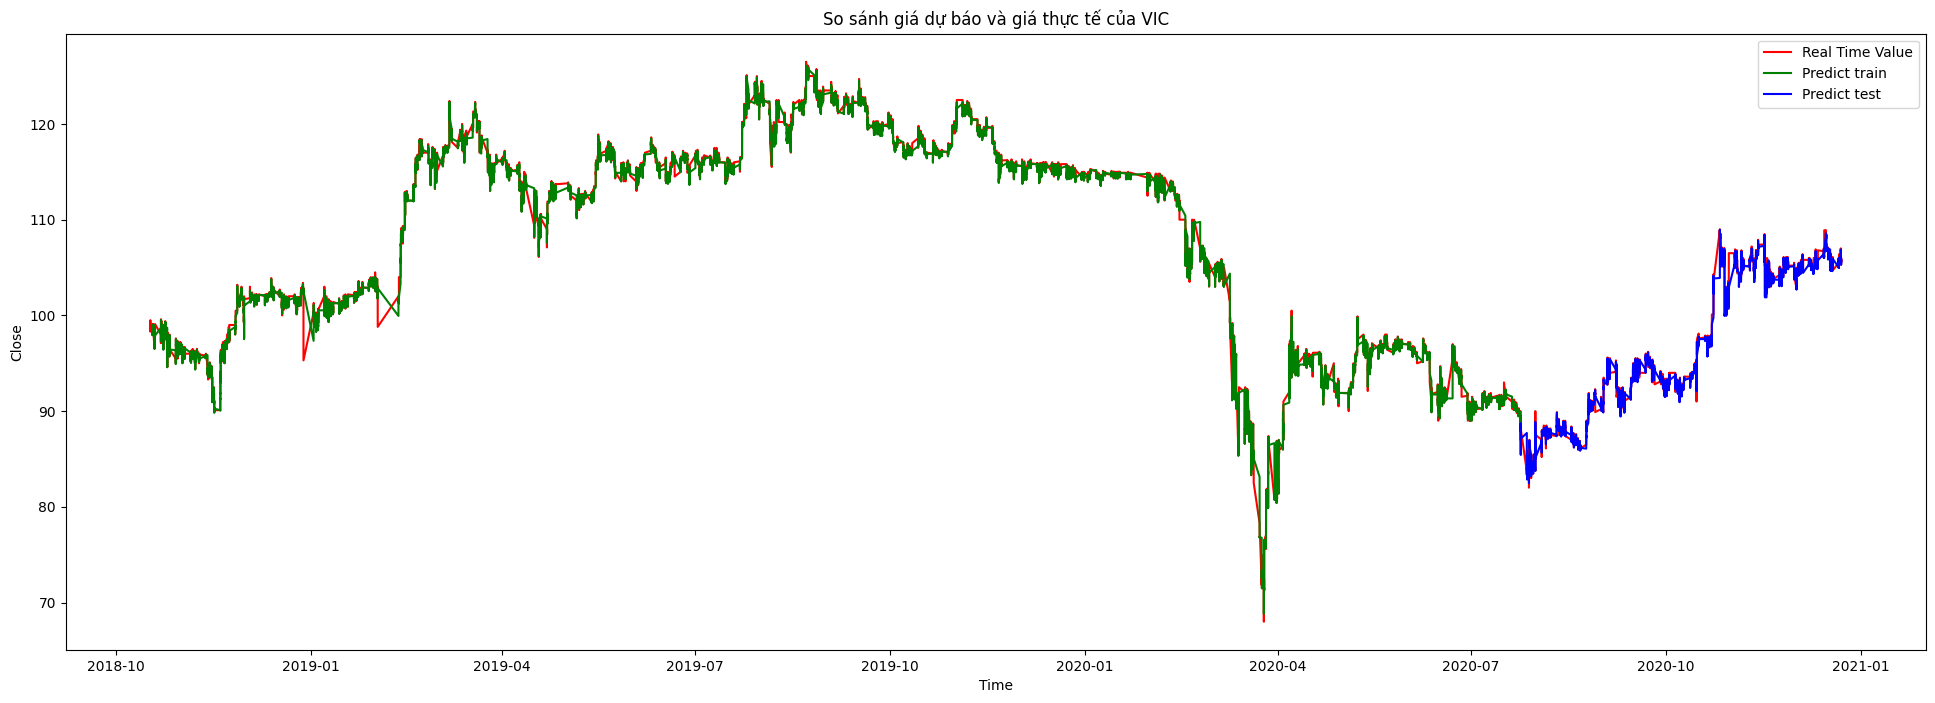

In [32]:
train_data1 = df[180:80000]
test_data1 = df[80000:]

plt.figure(figsize=(24,8))
plt.plot(df,label='Real Time Value',color='red') #đường giá thực
train_data1['Predict'] = y_train_pred #thêm dữ liệu
plt.plot(train_data1['Predict'],label='Predict train',color='green') #đường giá dự báo train
test_data1['Predict'] = y_test_predict #thêm dữ liệu
plt.plot(test_data1['Predict'],label='Predict test',color='blue') #đường giá dự báo test
plt.title('So sánh giá dự báo và giá thực tế của VIC')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.savefig("VIC_test.png")
plt.show()
